<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/NLP/text_classification_with_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
!nvidia-smi

Wed Jul 26 04:23:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-26 04:23:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-26 04:23:01 (92.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

#Load data

In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-07-26 04:23:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 142.251.172.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2023-07-26 04:23:03 (62.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
train_ds = pd.read_csv("train.csv")
test_ds = pd.read_csv("test.csv")

print(train_ds.shape)
print(test_ds.shape)


(7613, 5)
(3263, 4)


In [7]:
train_ds.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Check the lenght of text

<Axes: >

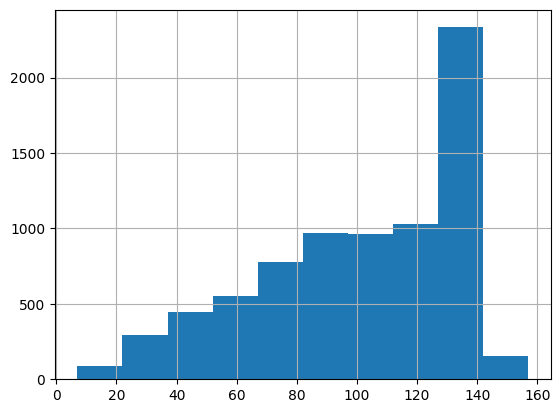

In [8]:
train_ds.text.str.len().hist()


In [9]:
train_ds.text.str.len().describe()


count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

#Create a custom Tokenizer that:
 1. clean data
 2. tokens data
 3. pad data

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class TextTokenizer():

  def __init__(self, max_vocab_size=1000, max_len=100, oov_token="<OOV>"):
    self.tokenizer = Tokenizer(
        num_words=max_vocab_size,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=' ',
        oov_token=oov_token)
    self.max_vocab_size = max_vocab_size
    self.max_len = max_len
    self.oov_token = oov_token
  def fit(self, X):
    self.tokenizer.fit_on_texts(X)

  def transform(self, X):
    seq = self.tokenizer.texts_to_sequences(X)
    return pad_sequences(seq, maxlen=self.max_len,padding='post',truncating='post')

  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)


In [11]:
tokenizer = TextTokenizer(max_vocab_size=10000, max_len=30)
t = tokenizer.fit_transform(train_ds[:10].text)


In [12]:
t[8]


array([91, 92, 93,  8, 94, 95,  2,  3, 96, 97,  3, 98,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [13]:
train_ds.iloc[8].text, train_ds.iloc[0]["target"]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [14]:
for i in t[8]:
  if i!=0:
    print(tokenizer.tokenizer.index_word[i])


there's
an
emergency
evacuation
happening
now
in
the
building
across
the
street


## Split data to train and validation set

In [15]:
import sklearn
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val  = train_test_split(train_ds.text, train_ds.target, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(6090,) (1523,) (6090,) (1523,)


In [16]:
#apply tokenizer

In [17]:
x_train = tokenizer.fit_transform(x_train)
x_val = tokenizer.transform(x_val)

In [18]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(6090, 30) (1523, 30) (6090,) (1523,)


In [19]:
tokenizer.max_vocab_size

10000

In [20]:
x_train.shape

(6090, 30)

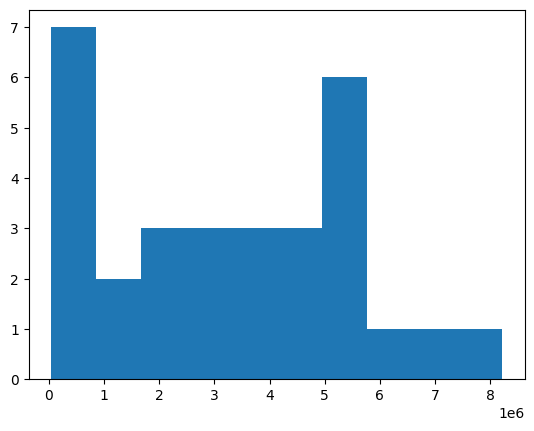

In [21]:
plt.hist(x_train.sum(axis = 0))
plt.show()


In [22]:
x_train.sum(axis = 0)

array([8212656, 6743533, 5708836, 5839085, 5665322, 5343371, 5225919,
       5166315, 5277959, 4707601, 4565893, 4471273, 4127299, 4088881,
       3733720, 3306197, 3189769, 2591975, 2361869, 2120306, 1901181,
       1495080,  982700,  841034,  553314,  270693,  126874,   82688,
         55304,   43967])

## Create nlp model using LSTP and enbedding layers

In [23]:
#check shape of input
x_train.shape, x_val.shape


((6090, 30), (1523, 30))

In [24]:
x_train[100]

array([6175, 6176,  636,  598, 2488,   17, 6177, 4051, 1106,   11,  230,
       6178,   20,    6, 1107, 3099,   26,    2,    4,    2,    3, 6179,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [25]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout
from tensorflow.keras.models import Model

def create_model(vocab_size, phrase_size, embedding_dim, rnn_units, batch_size):
    inputs = Input(shape=(phrase_size,))
    x = Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None])(inputs)
    x = LSTM(rnn_units, dropout = 0.5, recurrent_dropout=0.5)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

    return model

In [26]:
rnn_model = create_model(
    vocab_size=tokenizer.max_vocab_size,
    phrase_size=x_train.shape[1],
    embedding_dim=16,
    rnn_units=16,
    batch_size=32)

rnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 16)            160000    
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 162,129
Trainable params: 162,129
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
191/191 [==============================] - 60s 237ms/step - loss: 0.6447 - accuracy: 0.6240 - val_loss: 0.5227 - val_accuracy: 0.7787
Epoch 2/10
191/191 [==============================] - 31s 163ms/step - loss: 0.4621 - accuracy: 0.8144 - val_loss: 0.4619 - val_accuracy: 0.7892
Epoch 3/10
191/191 [==============================] - 32s 166ms/step - loss: 0.3675 - accuracy: 0.8652 - val_loss: 0.4480 - val_accuracy: 0.8024
Epoch 4/10
191/191 [==============================] - 28s 149ms/step - loss: 0.3064 - accuracy: 0.8964 - val_loss: 0.5361 - val_accuracy: 0.7899
Epoch 5/10
191/191 [==============================] - 28s 145ms/step - loss: 0.2696 - accuracy: 0.9103 - val_loss: 0.5438 - val_accuracy: 0.7945
Epoch 6/10
191/191 [==============================] - 30s 156ms/step - loss: 0.2356 - accuracy: 0.9236 - val_loss: 0.5314 - val_accuracy: 0.7978
Epoch 7/10
191/191 [==============================] - 28s 149ms/step - loss: 0.2177 - accuracy: 0.9289 - val_loss: 0.5871 - val_ac

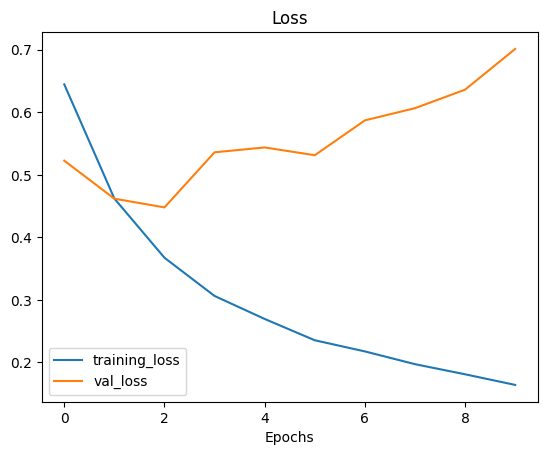

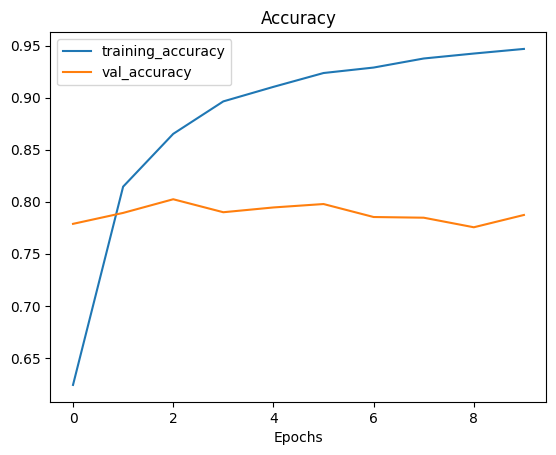

In [27]:
history_rnn = rnn_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))
plot_loss_curves(history_rnn)


##Create a model using Bidirectional LSTM

In [28]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout
from tensorflow.keras.models import Model

def create_bidiretional_lstm(vocab_size, phrase_size, embedding_dim, rnn_units, batch_size):
    inputs = Input(shape=(phrase_size,))
    x = Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None])(inputs)
    x = Bidirectional(LSTM(rnn_units))(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

    return model

In [29]:
b_lstm_model = create_bidiretional_lstm(
    vocab_size=tokenizer.max_vocab_size,
    phrase_size=x_train.shape[1],
    embedding_dim=16,
    rnn_units=16,
    batch_size=32)

b_lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 164,257
Trainable params: 164,257
Non-trainable params: 0
_____________________________________________________

Epoch 1/100
191/191 [==============================] - 21s 79ms/step - loss: 0.6354 - accuracy: 0.6411 - val_loss: 0.5284 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 4s 20ms/step - loss: 0.4100 - accuracy: 0.8322 - val_loss: 0.4373 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 4s 23ms/step - loss: 0.2734 - accuracy: 0.8966 - val_loss: 0.5155 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.1989 - accuracy: 0.9319 - val_loss: 0.5555 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 2s 12ms/step - loss: 0.1485 - accuracy: 0.9522 - val_loss: 0.6616 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0980 - accuracy: 0.9724 - val_loss: 0.7144 - val_accuracy: 0.7748 - lr: 2.0000e-04
Epoch 7/100
191/191 [==============================] 

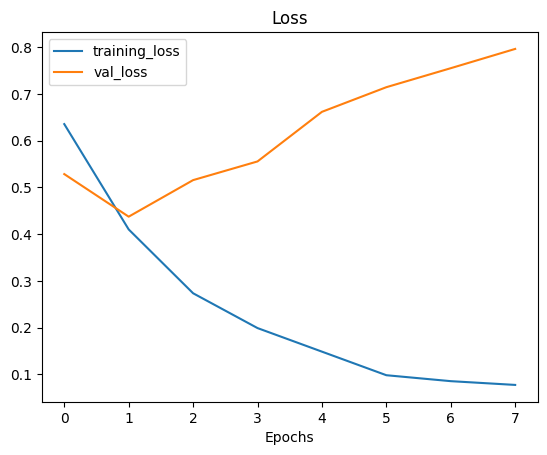

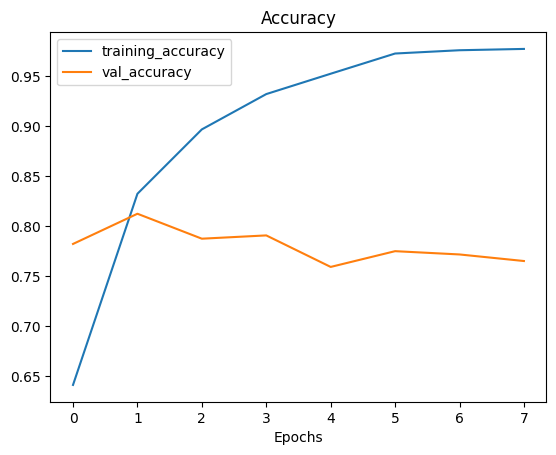

In [30]:
MC_b_lsmt = tf.keras.callbacks.ModelCheckpoint("b_lstm.h5", monitor="val_accuracy", save_best_only=True)
ES_b_lsmt = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
LRC_b_lsmt = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.2, min_lr=0.00001)

history_b_lstm = b_lstm_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100, validation_data=(x_val, y_val),
    callbacks = [MC_b_lsmt, ES_b_lsmt, LRC_b_lsmt])
plot_loss_curves(history_b_lstm)

### Create model using Conv1D layer

In [49]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def create_model_cnn1(vocab_size, phrase_size, embedding_dim, rnn_units, batch_size= 32):
    inputs = Input(shape=(phrase_size,))
    x = Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None])(inputs)
    x = Conv1D(4, 3, activation="relu")(x)
    x = MaxPooling1D(8)(x)
    x = LSTM(rnn_units, dropout = 0.5, recurrent_dropout=0.5)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

    return model

In [108]:
rnn_cnn = create_model_cnn1(
    vocab_size=tokenizer.max_vocab_size,
    phrase_size=x_train.shape[1],
    embedding_dim=16,
    rnn_units=4)

rnn_cnn.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_23 (Embedding)    (None, 30, 16)            160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 4)             196       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 4)             0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 4)                 144       
                                                                 
 dense_32 (Dense)            (None, 8)                 40        
                                                          

Epoch 1/100
191/191 [==============================] - 23s 92ms/step - loss: 0.6779 - accuracy: 0.5778 - val_loss: 0.6403 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 8s 40ms/step - loss: 0.5927 - accuracy: 0.6867 - val_loss: 0.5107 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 8s 40ms/step - loss: 0.4910 - accuracy: 0.7706 - val_loss: 0.4691 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 7s 38ms/step - loss: 0.3994 - accuracy: 0.8365 - val_loss: 0.4808 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 5s 28ms/step - loss: 0.3534 - accuracy: 0.8509 - val_loss: 0.5003 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 6s 32ms/step - loss: 0.2962 - accuracy: 0.8895 - val_loss: 0.5224 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 7/100
191/191 [==============================] - 5s

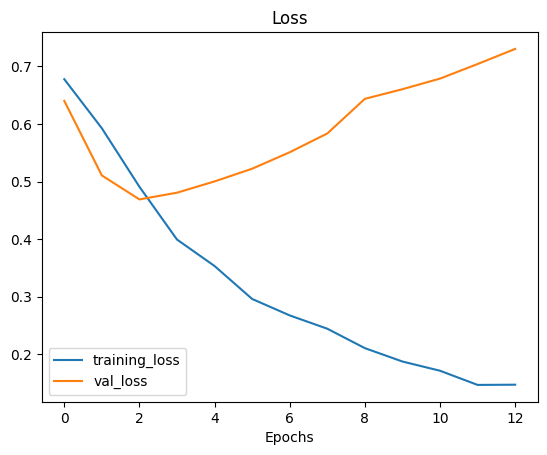

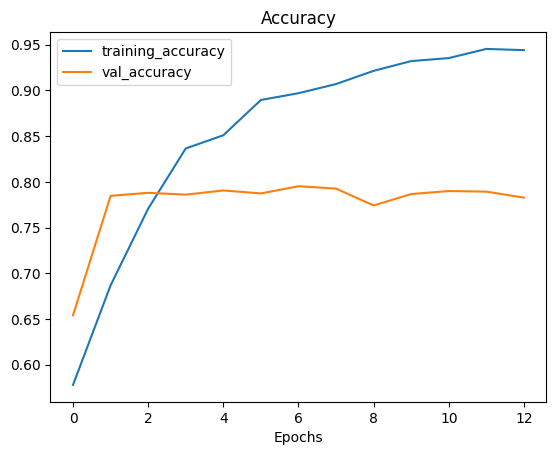

In [52]:
MC = tf.keras.callbacks.ModelCheckpoint("rnn_cnn.h5", monitor="val_accuracy", save_best_only=True)
ES = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
LRC = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.2, min_lr=0.00001)

history_rnn_cnn = rnn_cnn.fit(
    x_train, y_train,
    batch_size=32, epochs=100,
    validation_data=(x_val, y_val),
    callbacks = [MC, ES, LRC])
plot_loss_curves(history_rnn_cnn)

In [107]:
rnn_cnn.evaluate(x_val, y_val)

48/48 [==============================] - 0s 5ms/step - loss: 0.5510 - accuracy: 0.7951


[0.5510057806968689, 0.7951411604881287]

## Create RNN using GRU - gated recurring unit

In [112]:
from tensorflow.keras.layers import GRU

def create_model_gru(vocab_size, phrase_size, embedding_dim, rnn_units, batch_size= 32):
    inputs = Input(shape=(phrase_size,))
    x = Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None])(inputs)
    #x = tf.keras.layers.GlobalAveragePooling1D()(x)

    print(x.shape)
    x = GRU(rnn_units, dropout=0.4)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

    return model

In [113]:
rnn_gru = create_model_gru(
    vocab_size=tokenizer.max_vocab_size,
    phrase_size=x_train.shape[1],
    embedding_dim=16,
    rnn_units=8)

rnn_gru.summary()

(None, 30, 16)
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_25 (Embedding)    (None, 30, 16)            160000    
                                                                 
 gru_11 (GRU)                (None, 8)                 624       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,633
Trainable params: 160,633
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
191/191 [==============================] - 17s 73ms/step - loss: 0.6855 - accuracy: 0.5644 - val_loss: 0.6821 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 5s 25ms/step - loss: 0.6834 - accuracy: 0.5698 - val_loss: 0.6802 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 2s 10ms/step - loss: 0.5841 - accuracy: 0.6860 - val_loss: 0.4692 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.3784 - accuracy: 0.8514 - val_loss: 0.4488 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 2s 10ms/step - loss: 0.2980 - accuracy: 0.8944 - val_loss: 0.4692 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 2s 9ms/step - loss: 0.2479 - accuracy: 0.9118 - val_loss: 0.5108 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 7/100
191/191 [==============================] - 2s 

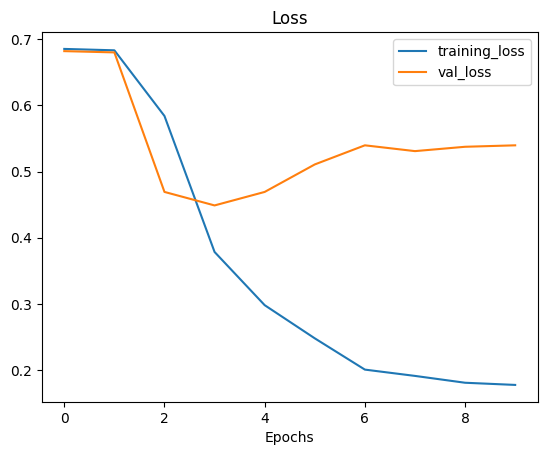

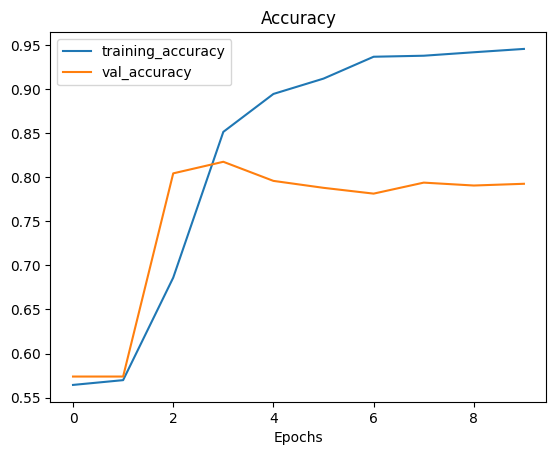

In [116]:
MC_GRU = tf.keras.callbacks.ModelCheckpoint("rnn_gru.h5", monitor="val_accuracy", save_best_only=True)
ES_GRU = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
LRC_GRU = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=0.2, min_lr=0.00001)

history_rnn_gru = rnn_gru.fit(
    x_train, y_train,
    batch_size=32, epochs=100,
    validation_data=(x_val, y_val),
    callbacks = [MC_GRU, ES_GRU, LRC_GRU])
plot_loss_curves(history_rnn_gru)

In [117]:
rnn_gru.evaluate(x_val, y_val)

48/48 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.8175


[0.44882145524024963, 0.8174655437469482]

### Compare models

In [118]:
loss1, acc1 = rnn_model.evaluate(x_val, y_val)
loss2, acc2 = b_lstm_model.evaluate(x_val, y_val)
loss3, acc3 = rnn_cnn.evaluate(x_val, y_val)
loss3, acc4 = rnn_gru.evaluate(x_val, y_val)

48/48 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.8175


### Saving the models and tokenizers

In [39]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [40]:
rnn_cnn.save("model_rnn_cnn.h5")
rnn_model.save("model_rnn.h5")
b_lstm_model.save("model_b_lstm.h5")

In [41]:
text_not_disaster="Life like an ensemble: take the best choices from others and make your own"
text_disaster="Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"


In [42]:
token_not_disaster = tokenizer.transform([text_not_disaster])
token_disaster = tokenizer.transform([text_disaster])


In [43]:
token_not_disaster.shape, token_disaster.shape


((1, 30), (1, 30))

In [44]:
# rnn predicts
pr_not_disaster = rnn_model.predict(token_not_disaster)
pr_disaster = rnn_model.predict(token_disaster)

pr_not_disaster, pr_disaster

1/1 [==============================] - 0s 41ms/step


(array([[0.00777986]], dtype=float32), array([[0.99434596]], dtype=float32))

In [45]:
# rnn_cnn predicts

pr_not_disaster_cnn = rnn_cnn.predict(token_not_disaster)
pr_disaster_cnn = rnn_cnn.predict(token_disaster)

pr_not_disaster_cnn, pr_disaster_cnn

1/1 [==============================] - 0s 29ms/step


(array([[0.19962886]], dtype=float32), array([[0.6817393]], dtype=float32))

In [46]:
# bidirectional predicts
pr_not_disaster_b = b_lstm_model.predict(token_not_disaster)
pr_disaster_b = b_lstm_model.predict(token_disaster)

pr_not_disaster_b, pr_disaster_b

1/1 [==============================] - 0s 20ms/step


(array([[0.08869642]], dtype=float32), array([[0.7003002]], dtype=float32))